In [1]:
import numpy as np
import scipy as sp
from PIL import Image

import matplotlib.pylab as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D

import scipy.stats as st
from sortedcontainers import SortedDict
from skimage.restoration import unwrap_phase

from IPython.display import HTML

import math
import random

from scipy.optimize import curve_fit, minimize

In [2]:
def show_wave(wave):
    fig,ax = plt.subplots(1,2)
    ax1 = ax[0]
    ax2 = ax[1]

    ax[0].set_title("Magnitude")
    ax[1].set_title("Phase")
    
    wave_abs = np.abs(wave)
    wave_phase = np.angle(wave)
        
    plt1 = ax1.imshow(wave_abs)
    plt2 = ax2.imshow(wave_phase)

In [3]:
class WaveAnimation(animation.TimedAnimation):
    def __init__(self,data):
        fig,ax = plt.subplots(1,2)
        self.ax1 = ax[0]
        self.ax2 = ax[1]
        
        ax[0].set_title("Magnitude")
        ax[1].set_title("Phase")
        
        self.data = data
        self.t = len(data)

        animation.TimedAnimation.__init__(self, fig, interval=1000, blit=True)

    def _draw_frame(self, framedata):
        i = framedata#-1
        wave_abs = np.abs(self.data[i])
        wave_phase = np.angle(self.data[i])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        self._drawn_artists = [plt1,plt2]

    def new_frame_seq(self):
        return iter(range(self.t))

    def _init_draw(self):
        wave_abs = np.abs(self.data[0])
        wave_phase = np.angle(self.data[0])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        
    def close(self):
        plt.close()

In [4]:
class WaveAnimationWithHist(animation.TimedAnimation):
    def __init__(self,data):
        fig,ax = plt.subplots(1,3)
        self.ax1 = ax[0]
        self.ax2 = ax[1]
        self.ax3 = ax[2]
        
        ax[0].set_title("Magnitude")
        ax[1].set_title("Phase")
        ax[2].set_title("Histogram")
        
        self.data = data
        self.t = len(data)

        animation.TimedAnimation.__init__(self, fig, interval=1000, blit=True)

    def _draw_frame(self, framedata):
        i = framedata#-1
        wave_abs = np.abs(self.data[i])
        wave_phase = np.angle(self.data[i])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        plt3 = self.ax3.hist(wave_abs.flatten(),30)
        self._drawn_artists = [plt1,plt2]

    def new_frame_seq(self):
        return iter(range(self.t))

    def _init_draw(self):
        wave_abs = np.abs(self.data[0])
        wave_phase = np.angle(self.data[0])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        plt3 = self.ax3.hist(wave_abs.flatten(),30)
        
    def close(self):
        plt.close()

In [5]:
def get_kernel(wavelength,z,dx,dy,x,y):
    kernelFactor = 2*math.pi*z/wavelength
    
    dfx = 1/(dx*x)
    dfy = 1/(dy*y)
    
    # Count up then down eg: [0,1,2,1,0]
    if x % 2 == 0:
        x2 = np.append(np.arange(x/2),np.flip(np.arange(x/2)))
    else:
        x2 = np.append(np.arange((x/2)-1),[math.ceil(x/2)])
        x2 = np.append(x2,np.flip(np.arange((x/2)-1)))
        
    if y % 2 == 0:
        y2 = np.append(np.arange(y/2),np.flip(np.arange(y/2)))
    else:
        y2 = np.append(np.arange((y/2)-1),[math.ceil(y/2)])
        y2 = np.append(y2,np.flip(np.arange((y/2)-1)))
    
    l = x2 - (x/2) + 1
    l2 = (l**2) * (dfx**2)
    
    m = y2 - (y/2) + 1
    m2 = (m**2) * (dfy**2) + 1
    
    l2 = np.arange(x)-int(x/2)
    m2 = np.arange(y)-int(y/2)
    
    l3 = np.broadcast_to(l2, (y,x)).transpose()
    m3 = np.broadcast_to(m2, (x,y))
    
    kernelPhase = np.power(1 - (wavelength*l3/dx)**2 - (wavelength*m3/dy)**2,(1/2)) * kernelFactor
    
    return np.exp(kernelPhase*1j)

(300, 250)


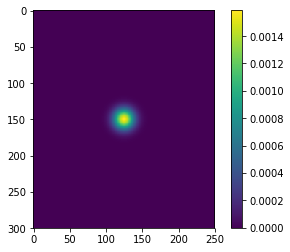

In [6]:
# https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma

#TODO: Get sigma, size right
def generate_gaussian_grid(size_x,size_y,sigma_x=3.,sigma_y=3.):
    #size_x *= 2
    #size_y *= 2
    
    x = np.linspace(-int(size_x/2), int(size_x/2), size_x)
    y = np.linspace(-int(size_y/2), int(size_y/2), size_y)

    x, y = np.meshgrid(x, y)
    z = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(x**2/(2*sigma_x**2) + y**2/(2*sigma_y**2))))
    #plt.contourf(x, y, z, cmap='Blues')
    #plt.colorbar()
    #plt.show()
    
    #z = z[int(size_y/2):,:int(size_x/2)].transpose()
    
    return z

#print(z.shape)

#plt.contourf(x, y, z, cmap='Blues')
#plt.colorbar()
#plt.show()

gauss = generate_gaussian_grid(250,300,10,10)
plt.imshow(gauss)
plt.colorbar()
#plt.hist(gauss.flatten(),50)
print(gauss.shape)

-9.549694368615746e-16
1.0


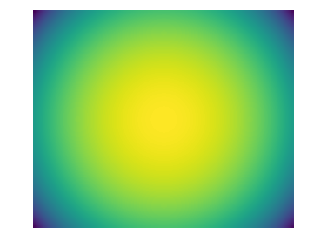

In [7]:
def gen_sphere(x,y,r=50):
    #x *= 2
    #y *= 2
    circ = np.zeros((x,y))

    r2 = np.power(r,2)
    
    pos_x = x/2
    pos_y = y/2
    
    for i in range(x):
        x2 = np.power(i-pos_x,2)
        for j in range(y):
            
            circ[i][j] = np.power(max(0,r2-(x2+np.power(j-pos_y,2))),1/2)
            
    circ = sp.ndimage.filters.gaussian_filter(circ,sigma=3)
    
    mean = np.mean(circ)
    sd = np.std(circ)
    
    circ = (circ-mean)/sd
    
    return circ

sphere = gen_sphere(250,300,200)
plt.imshow(sphere)
plt.axis('off')

print(np.mean(sphere))
print(np.std(sphere))

In [9]:
def get_gauss_beam(x,y):
    #gauss = generate_gaussian_grid(x,y,x*0.05,y*0.05).transpose()
    #sphere = gen_sphere(x,y,x*0.05)
    gauss = generate_gaussian_grid(x,y,x*0.4,y*0.4).transpose()
    sphere = gen_sphere(x,y,x*0.2)
    gauss = gauss * (np.cos(sphere) + 1j*np.sin(sphere))
    #gauss = gauss * (np.cos(np.ones((x,y))) + 1j*np.sin(np.ones((x,y))))
    return gauss

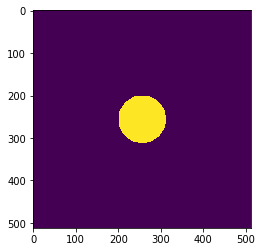

In [28]:
aperture = np.zeros([x,y])
for k in range(x):
    for j in range(y):
        r = np.sqrt((k-x/2)**2+(j-y/2)**2)
        if r < x/2-200:
            aperture[k,j] = 1

#aperture[400:600,400:600] = 1

plt.imshow(aperture)

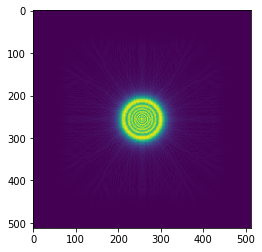

In [29]:
x = 512
y = 512
wavelength = 0.535

gauss = get_gauss_beam(x,y)
plane = np.ones((x,y))
#aperture = np.zeros((x,y))
#aperture[246:266,236:276] = 1

#post_ap = gauss*aperture
post_ap = plane*aperture

kernel = get_kernel(wavelength,100,x*0.5,y*0.5,x,y)
fft_post_ap = np.fft.fftshift(np.fft.fft2(post_ap))

fft_proped = kernel * fft_post_ap
proped = np.fft.ifft2(np.fft.ifftshift(fft_proped))

plt.imshow(np.abs(proped))

In [2]:
class VideoReconstructor():
    def __init__(self):
        self.popt = None
        self.z = 0
        self.show_details = False
        self.autofocus = False
        self.step_size = 500

        self.wavelength   = 0.6283              # Wavelength of laser, micron
        self.dx=0.424
        self.dy=0.424
        self.dz=1.503

In [3]:
class VideoReconstructor(VideoReconstructor):
    def get_kernel(self,z,size_x,size_y):
        kernelFactor = 2*math.pi*z/self.wavelength

        dfx = 1/(self.dx*size_x)
        dfy = 1/(self.dy*size_y)

        # Count up then down eg: [0,1,2,1,0]
        if size_x % 2 == 0:
            x2 = np.append(np.arange(size_x/2),np.flip(np.arange(size_x/2)))
        else:
            x2 = np.append(np.arange((size_x/2)-1),[math.ceil(size_x/2)])
            x2 = np.append(x2,np.flip(np.arange((size_x/2)-1)))

        if size_y % 2 == 0:
            y2 = np.append(np.arange(size_y/2),np.flip(np.arange(size_y/2)))
        else:
            y2 = np.append(np.arange((size_y/2)-1),[math.ceil(size_y/2)])
            y2 = np.append(y2,np.flip(np.arange((size_y/2)-1)))

        l = x2 - (size_x/2) + 1
        l2 = (l**2) * (dfx**2)

        m = y2 - (size_y/2) + 1
        m2 = (m**2) * (dfy**2) + 1

        l2 = np.arange(size_x)-int(size_x/2)
        m2 = np.arange(size_y)-int(size_y/2)

        l3 = np.broadcast_to(l2, (size_y,size_x)).transpose()
        m3 = np.broadcast_to(m2, (size_x,size_y))

        #print(l3)
        #print(m3)

        kernelPhase = np.power(1 - (self.wavelength*l3/self.dx)**2 - (self.wavelength*m3/self.dy)**2,(1/2)) * kernelFactor

        real = np.cos(kernelPhase)
        img = 1j*np.sin(kernelPhase)

        return real+img

In [6]:
vr = VideoReconstructor()
vr.dx = 512*0.5
vr.dy = 512*0.5
vr.get_kernel(0,512,512)

array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]])